In [2]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
# Load Hyperspectral Data & Ground Truth Labels
data = sio.loadmat('/content/PaviaU.mat')['paviaU']
labels = sio.loadmat('/content/PaviaU_gt.mat')['paviaU_gt']

print("Original Data Shape:", data.shape)   # (145, 145, 200)
print("Ground Truth Shape:", labels.shape)   # (145, 145)


Original Data Shape: (610, 340, 103)
Ground Truth Shape: (610, 340)


In [4]:
X = data.reshape(-1, data.shape[2])   # (10249, 200)
y = labels.reshape(-1)                # (10249,)

# Remove background pixels (label=0)
mask = y > 0
X = X[mask]  # Select labeled pixels
y = y[mask]



In [5]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)  # Reduce spectral bands (200 → 50)

print("PCA Reduced Shape:", X_pca.shape)  # (Number of labeled pixels, 50)


PCA Reduced Shape: (42776, 50)


In [6]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_pca)  # Standardization (zero mean, unit variance)


In [7]:
X_cnn = X_norm.reshape(-1, 50, 1)  # Reshape to 3D for Conv1D
print("Reshaped Data for CNN:", X_cnn.shape)  # (Num_samples, Features, 1)


Reshaped Data for CNN: (42776, 50, 1)


In [8]:
y_encoded = to_categorical(y - 1)  # Adjust labels to start from 0
print("One-Hot Encoded Labels Shape:", y_encoded.shape)  # (num_samples, 16)


One-Hot Encoded Labels Shape: (42776, 9)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_encoded, test_size=0.2, random_state=42, stratify=y
)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (34220, 50, 1)
Testing Data Shape: (8556, 50, 1)


In [11]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(50, 1)),

    Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(9, activation='softmax')
])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 50, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 25, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,945 (234.16 KB)

 Trainable params: 59,849 (233.79 KB)

 Non-trainable params: 96 (384.00 B)

None


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)


Epoch 1/20
1070/1070 - 23s - 22ms/step - accuracy: 0.6624 - loss: 1.2137 - val_accuracy: 0.8367 - val_loss: 0.6261
Epoch 2/20
1070/1070 - 4s - 4ms/step - accuracy: 0.8368 - loss: 0.6396 - val_accuracy: 0.9003 - val_loss: 0.4647
Epoch 3/20
1070/1070 - 5s - 5ms/step - accuracy: 0.8756 - loss: 0.5086 - val_accuracy: 0.9084 - val_loss: 0.3933
Epoch 4/20
1070/1070 - 5s - 5ms/step - accuracy: 0.8954 - loss: 0.4398 - val_accuracy: 0.9222 - val_loss: 0.3481
Epoch 5/20
1070/1070 - 5s - 5ms/step - accuracy: 0.9013 - loss: 0.4104 - val_accuracy: 0.9260 - val_loss: 0.3250
Epoch 6/20
1070/1070 - 5s - 4ms/step - accuracy: 0.9073 - loss: 0.3889 - val_accuracy: 0.9212 - val_loss: 0.3423
Epoch 7/20
1070/1070 - 4s - 3ms/step - accuracy: 0.9086 - loss: 0.3767 - val_accuracy: 0.9230 - val_loss: 0.3393
Epoch 8/20
1070/1070 - 5s - 5ms/step - accuracy: 0.9155 - loss: 0.3698 - val_accuracy: 0.9277 - val_loss: 0.3284
Epoch 9/20
1070/1070 - 4s - 4ms/step - accuracy: 0.9180 - loss: 0.3596 - val_accuracy: 0.9310 

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 1000x800 with 0 Axes>

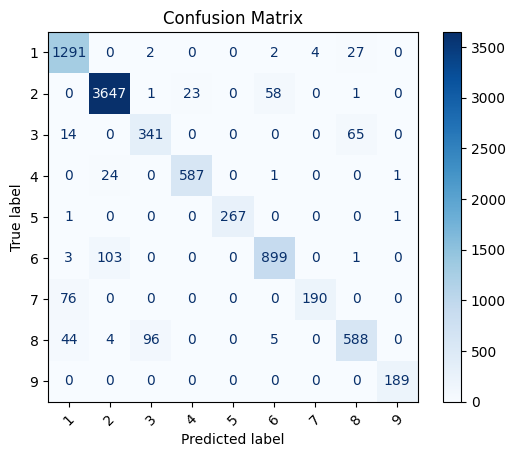

In [14]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 10))

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Compute and display precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.71      0.81      0.76       286
           2       0.80      0.68      0.74       166
           3       0.79      0.40      0.54        47
           4       0.95      0.86      0.90        97
           5       0.88      0.97      0.93       146
           6       1.00      0.80      0.89         5
           7       0.94      1.00      0.97        96
           8       0.67      0.50      0.57         4
           9       0.76      0.86      0.80       194
          10       0.87      0.82      0.84       491
          11       0.71      0.79      0.75       119
          12       0.98      0.98      0.98        41
          13       0.91      0.98      0.94       253
          14       0.74      0.48      0.58        77
          15       0.94      0.84      0.89        19

    accuracy                           0.83      2050
   